In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pandasql import sqldf
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import ttest_1samp
import seaborn as sns
%matplotlib inline

#load in data sets
boxoffice = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)

#connect to database
conn = sqlite3.connect('zippedData/im.db')

pysqldf = lambda q: sqldf(q, globals()) # needed this to merge SQL with pandas dataframe for our master dataframe

In [2]:
#Joined two tables (movie_basics and movie_ratings) within the SQL dataframe
joined = pd.read_sql("SELECT * FROM movie_basics mb JOIN movie_ratings mr ON mb.movie_id=mr.movie_id", conn)

#Joined the previous merged SQL tables to another pandas data frame with the movie title as the identifier
q = """
SELECT * FROM joined j 
JOIN movie_budgets mb ON mb.movie=j.primary_title 
JOIN movies m ON m.original_title=j.original_title
"""
master_df = pysqldf(q).drop_duplicates(subset='primary_title', keep='first')

#Dropping columns that are not relevant for our analysis for a cleaner look
new_master_df = master_df.drop(["original_title", "id", "start_year", "movie", "title", 
                                "genre_ids", "original_language"], axis=1)

#Renaming columns to differentiate between the two datasets 
new_master_df = new_master_df.rename(columns={"vote_average": "tmdb_vote_average",
                                              "vote_count": "tmdb_vote_count", "averagerating": "imdb_average_rating", 
                                              "numvotes": "imdb_vote_count"})
#Converting genres column into a list
new_master_df["genres"] = new_master_df["genres"].str.split(',')

new_master_df

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,release_date,production_budget,domestic_gross,worldwide_gross,popularity,release_date,tmdb_vote_average,tmdb_vote_count
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,"Dec 31, 2012","$45,000,000",$0,"$73,706",4.705,2013-05-07,2.1,46
1,tt0326592,The Overnight,88.0,None,7.5,24,"Jun 19, 2015","$200,000","$1,109,808","$1,165,996",6.576,2015-06-19,6.0,200
2,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302",8.919,2012-12-21,5.6,518
3,tt0359950,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,275300,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183",10.743,2013-12-25,7.1,4859
4,tt0365907,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,105116,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587",19.373,2014-09-19,6.3,1685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,tt7401588,Instant Family,118.0,"[Comedy, Drama]",7.4,46728,"Nov 16, 2018","$48,000,000","$67,363,237","$119,736,188",22.634,2018-11-16,7.6,782
2839,tt7766254,Big,99.0,[Documentary],8.5,6,"Jun 3, 1988","$18,000,000","$114,968,774","$151,668,774",15.031,1988-06-03,7.0,1813
2841,tt7784604,Hereditary,127.0,"[Drama, Horror, Mystery]",7.3,151571,"Jun 8, 2018","$10,000,000","$44,069,456","$70,133,905",26.185,2018-06-08,7.0,2491
2848,tt8043306,Teefa in Trouble,155.0,"[Action, Comedy, Crime]",7.4,2724,"Jul 20, 2018","$1,500,000",$0,"$98,806",4.486,2018-07-20,7.6,11


In [3]:
#Converting budget values from string into integers for calculations/graphs/further analysis
new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['worldwide_gross'] = new_master_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)

final_master_df = new_master_df
final_master_df

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,release_date,production_budget,domestic_gross,worldwide_gross,popularity,release_date,tmdb_vote_average,tmdb_vote_count
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,"Dec 31, 2012",45000000,0,73706,4.705,2013-05-07,2.1,46
1,tt0326592,The Overnight,88.0,None,7.5,24,"Jun 19, 2015",200000,1109808,1165996,6.576,2015-06-19,6.0,200
2,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,"Mar 22, 2013",25000000,720828,9313302,8.919,2012-12-21,5.6,518
3,tt0359950,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,275300,"Dec 25, 2013",91000000,58236838,187861183,10.743,2013-12-25,7.1,4859
4,tt0365907,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,105116,"Sep 19, 2014",28000000,26017685,62108587,19.373,2014-09-19,6.3,1685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,tt7401588,Instant Family,118.0,"[Comedy, Drama]",7.4,46728,"Nov 16, 2018",48000000,67363237,119736188,22.634,2018-11-16,7.6,782
2839,tt7766254,Big,99.0,[Documentary],8.5,6,"Jun 3, 1988",18000000,114968774,151668774,15.031,1988-06-03,7.0,1813
2841,tt7784604,Hereditary,127.0,"[Drama, Horror, Mystery]",7.3,151571,"Jun 8, 2018",10000000,44069456,70133905,26.185,2018-06-08,7.0,2491
2848,tt8043306,Teefa in Trouble,155.0,"[Action, Comedy, Crime]",7.4,2724,"Jul 20, 2018",1500000,0,98806,4.486,2018-07-20,7.6,11


In [4]:
#Assuming that the production budget includes all the costs of production, we are calculating the net profit from the 
#gross revenue and creating them into two new columns
final_master_df['domestic_profit'] = final_master_df['domestic_gross'] - final_master_df['production_budget']
final_master_df['worldwide_profit'] = final_master_df['worldwide_gross'] - final_master_df['production_budget']

# dropped additional columns and removed null values from genres
final = final_master_df
final = final.drop(['release_date'], axis=1)
final['genres'] = final['genres'].dropna()
final = final.dropna()
final.reset_index(drop=True)

#separated the rows to have the list of genres per film be seperated
final1 = final.explode('genres')
final1

<ipython-input-4-af4ad3eaf121>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['genres'] = final['genres'].dropna()


,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,Action,1.9,8248,45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Animation,1.9,8248,45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Comedy,1.9,8248,45000000,0,73706,4.705,2.1,46,-45000000,-44926294
2,tt0337692,On the Road,124.0,Adventure,6.1,37886,25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698
2,tt0337692,On the Road,124.0,Drama,6.1,37886,25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,tt7784604,Hereditary,127.0,Mystery,7.3,151571,10000000,44069456,70133905,26.185,7.0,2491,34069456,60133905
2848,tt8043306,Teefa in Trouble,155.0,Action,7.4,2724,1500000,0,98806,4.486,7.6,11,-1500000,-1401194
2848,tt8043306,Teefa in Trouble,155.0,Comedy,7.4,2724,1500000,0,98806,4.486,7.6,11,-1500000,-1401194
2848,tt8043306,Teefa in Trouble,155.0,Crime,7.4,2724,1500000,0,98806,4.486,7.6,11,-1500000,-1401194


In [5]:
max(final['worldwide_profit'])

1748134200

In [6]:
final[final['worldwide_profit'] == 1748134200 ]

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
2334,tt4154756,Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",8.5,670926,300000000,678815482,2048134200,80.773,8.3,13948,378815482,1748134200


In [7]:
max(final['popularity']) 

#the highest popularity rating was given to the movie that made the highest worldwide profit

80.773

Avengers Infinity War made the most net profit worldwide

Potential hypothesis testing:

- Null Hypothesis: The popularity rating does not affect the worldwide profitability or has a negative effect
- Alternate Hypothesis: The popularity rating positively impacts the worldwide profitability

Another thing to think about is that, we are assuming worldwide profitability includes domestic profitability. We are also 
assuming that domestic refers to the United States, so even if a movie is international we assume that the domestic budget
values assume that its the US for simplicity sake

In [8]:
max(final['domestic_profit'])

500059566

In [9]:
final[final['domestic_profit'] == 500059566 ]

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
1066,tt1825683,Black Panther,134.0,"[Action, Adventure, Sci-Fi]",7.3,516148,200000000,700059566,1348258224,44.14,7.4,12365,500059566,1148258224


Black Panther made the most net profit domestic

In [10]:
500059566 > 1748134200 #Avengers Infinity War made more than Black Panther which makes sense

False

Both films that made the most profit included the same genres [Action, Adventure, Sci-Fi]

A potential hypothesis testing can be:
- Null Hypothesis: The genre does not impact profitability
- Alternate Hypothesis: The genre does impact profitability

This might be a difficult one to do, but just an idea. Both are Marvel movies, but that information is not given in our 
master dataframe.

In [11]:
final[final['imdb_average_rating'] == max(final['imdb_average_rating'])]

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
575,tt1455256,The Wall,78.0,[Documentary],9.2,8,3000000,1803064,4495262,8.142,6.1,407,-1196936,1495262


In [12]:
final[final['tmdb_vote_average'] == max(final['tmdb_vote_average'])]
#all of them only have one vote count and very low popularity (assuming these values are percentage values)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
435,tt1334515,Bad Company,87.0,[Thriller],5.1,10,70000000,30157016,69157016,1.836,10.0,1,-39842984,-842984
1007,tt1772317,Nerve,83.0,"[Comedy, Drama]",6.8,88,20000000,38583626,70652284,0.600,10.0,1,18583626,50652284
1488,tt2248739,Departure,109.0,"[Drama, Romance]",6.7,1680,1100000,0,27561,0.885,10.0,1,-1100000,-1072439
2056,tt3319070,Emma,70.0,[Thriller],4.7,133,5900000,22231658,37831658,0.600,10.0,1,16331658,31931658
2089,tt3406296,Chemical Cut,83.0,[Drama],5.4,111,1000000,0,0,0.639,10.0,1,-1000000,-1000000


Another hypothesis testing could be analyzing the relationship between vote count and popularity rate. 

- The lower the vote count the lower the popularity compared to higher vote count and higher popularity

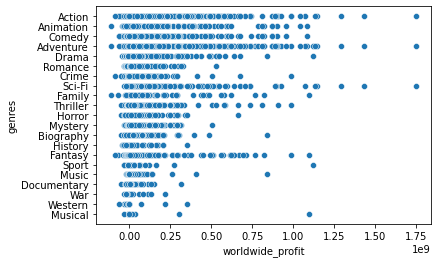

In [13]:
sns.scatterplot(y="genres",
x="worldwide_profit",
data=final1);

In [14]:
final1['genres'].value_counts()

Drama          876
Comedy         562
Action         454
Adventure      352
Thriller       312
Crime          271
Horror         230
Romance        221
Sci-Fi         149
Biography      148
Mystery        139
Fantasy        128
Animation      103
Family         101
Documentary     67
History         50
Music           48
Sport           38
War             21
Western         13
Musical         10
Name: genres, dtype: int64

# **DISREGARD EVERYTHING ABOVE BESIDES DATA CLEANING**

## Confidence Intervals

Given that our data set is not representative of a population of all movies rather it is a sample, we decided it would be best to find the confidence interval of the runtime minutes of a movie to have a range of values that most movies average around. With the confidence interval, we want to conduct hypothesis testing to test whether the range of values impacts profitability which will be done after calculating the confidence interval

In [15]:
runtime = pd.DataFrame(final, columns=['runtime_minutes'])
print(runtime.describe()) #runtime statistics across all genres

       runtime_minutes
count      1730.000000
mean        104.985549
std          17.788889
min          41.000000
25%          93.000000
50%         103.000000
75%         115.000000
max         180.000000


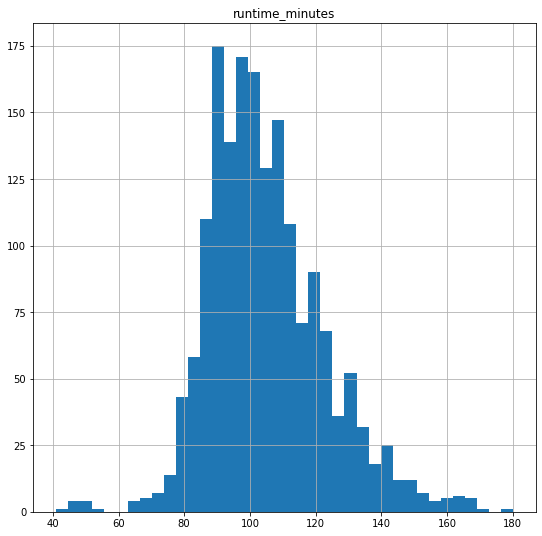

In [16]:
pd.DataFrame(runtime).hist(bins='auto',figsize=(9,9));

As you can see in the histogram above, the distribution of the runtime is unimodal and looks almost normal. Once again, given that our data is a sample rather than the population, we decided to directly calculate the confidence intervals based on the given data

In [17]:
runtime 
#we want to see if there is a relationship between runtime and profitability and have a confidence interval as a 
#recommendation for Computing Vision

,runtime_minutes
0,91.0
2,124.0
3,114.0
4,114.0
5,124.0
...,...
2825,118.0
2839,99.0
2841,127.0
2848,155.0


In [18]:
# Calculating the confidence interval within 1 standard deviation of the mean. A 68% chance that the runtime value would 
# fall in this range
stats.norm.interval(0.68, loc=runtime.mean(), scale=runtime.std())

(array([87.29524865]), array([122.67584961]))

We chose one standard deviation for runtime, because we didn't want a wide range of values for the runtime of the movie that would have a significant impact on other factors such as popularity or how many people watched it (this is an assumption).

According to our calculation above the runtime within one standard deviation ranges from approximately 87.3 minutes to 122.7 minutes

## Hypothesis Testing

Now that we have our confidence interval, we want to test if having a value within this range of runtime minutes (inclusive) positively impacts profitability. In simpler terms, does this range of runtime minutes ensure that the movie would be more profitable than movies with runtimes outside of this range.

#### Null Hypothesis: A runtime between 87.3 and 122.7 minutes will negatively impact or not impact profitability
#### Alternate Hypothesis: A runtime between 87.3 and 122.7 minutes will positively impact profitability

In [20]:
# stats.ttest_1samp(a=runtime, popmean=104.985549)